In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
import tensorflow as tf
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import layers, Sequential, callbacks
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

In [2]:
dataset = pd.read_csv("/content/traffic.csv")
dataset.head()

,DateTime,Junction,Vehicles,ID
0,2015-11-01 00:00:00,1,15,20151101001
1,2015-11-01 01:00:00,1,13,20151101011
2,2015-11-01 02:00:00,1,10,20151101021
3,2015-11-01 03:00:00,1,7,20151101031
4,2015-11-01 04:00:00,1,9,20151101041


In [3]:
data = dataset.copy()


In [4]:
data["DateTime"]= pd.to_datetime(data["DateTime"])
data = data.drop(["ID"], axis=1) #dropping IDs
data.info

<bound method DataFrame.info of                  DateTime  Junction  Vehicles
0     2015-11-01 00:00:00         1        15
1     2015-11-01 01:00:00         1        13
2     2015-11-01 02:00:00         1        10
3     2015-11-01 03:00:00         1         7
4     2015-11-01 04:00:00         1         9
...                   ...       ...       ...
48115 2017-06-30 19:00:00         4        11
48116 2017-06-30 20:00:00         4        30
48117 2017-06-30 21:00:00         4        16
48118 2017-06-30 22:00:00         4        22
48119 2017-06-30 23:00:00         4        12

[48120 rows x 3 columns]>

Text(0.5, 0, 'Date')

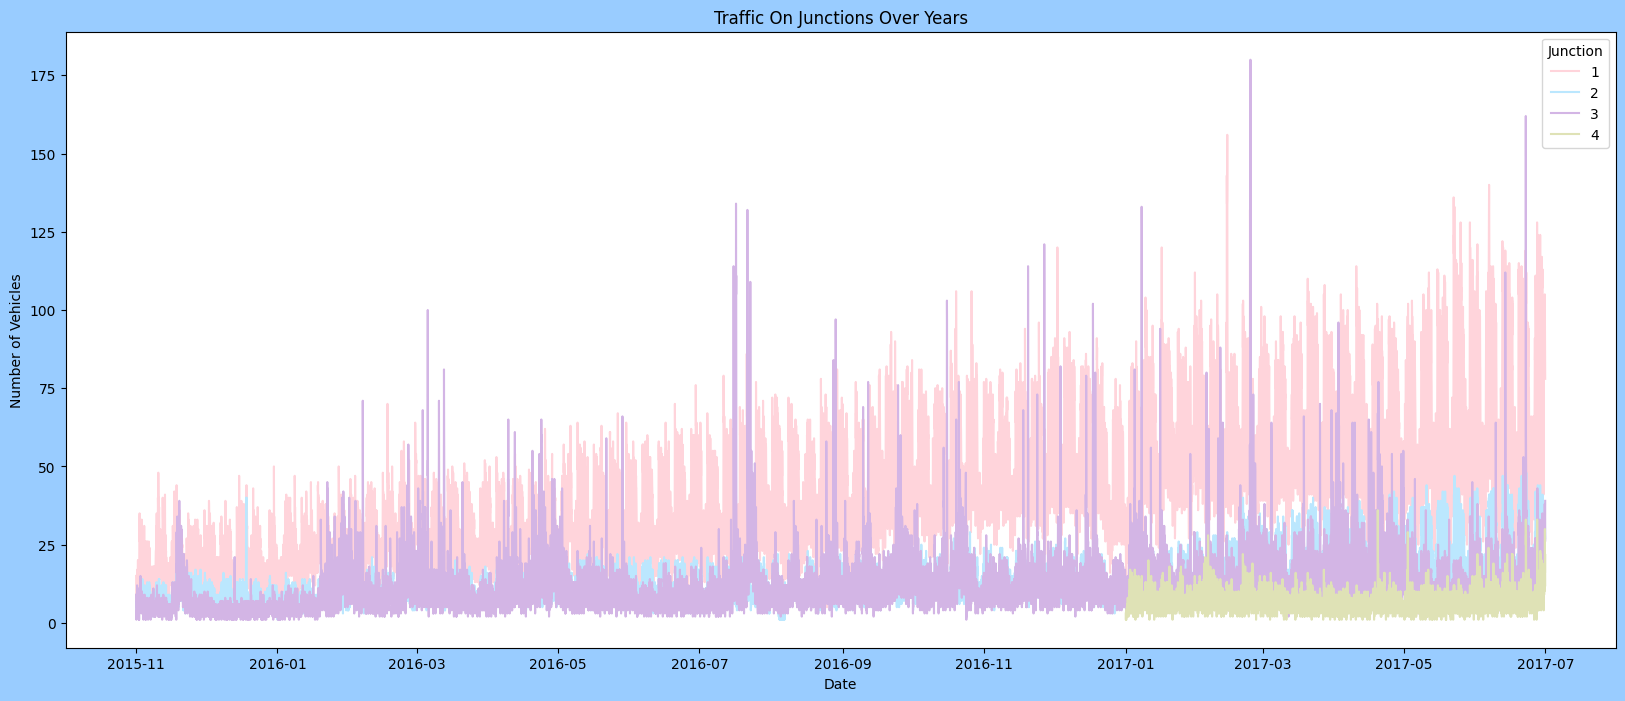

In [5]:
df=data.copy()
#Let's plot the Timeseries
colors = [ "#FFD4DB","#BBE7FE","#D3B5E5","#dfe2b6"]
plt.figure(figsize=(20,8),facecolor="#99ccff")
Time_series=sns.lineplot(x=df['DateTime'],y="Vehicles",data=df, hue="Junction", palette=colors)
Time_series.set_title("Traffic On Junctions Over Years")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")

In [6]:
df["Year"]= df['DateTime'].dt.year
df["Month"]= df['DateTime'].dt.month
df["Date_no"]= df['DateTime'].dt.day
df["Hour"]= df['DateTime'].dt.hour
df["Day"]= df.DateTime.dt.strftime("%A")
df.head()

,DateTime,Junction,Vehicles,Year,Month,Date_no,Hour,Day
0,2015-11-01 00:00:00,1,15,2015,11,1,0,Sunday
1,2015-11-01 01:00:00,1,13,2015,11,1,1,Sunday
2,2015-11-01 02:00:00,1,10,2015,11,1,2,Sunday
3,2015-11-01 03:00:00,1,7,2015,11,1,3,Sunday
4,2015-11-01 04:00:00,1,9,2015,11,1,4,Sunday


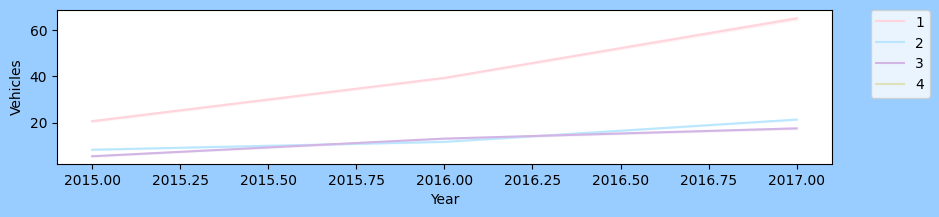

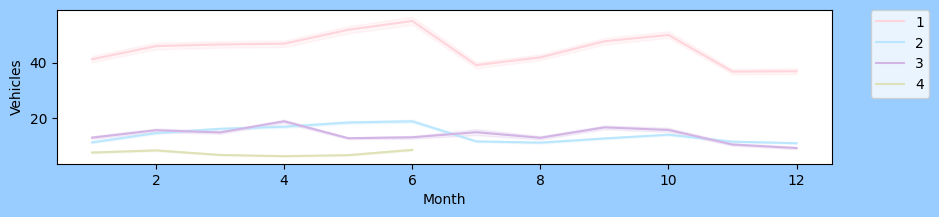

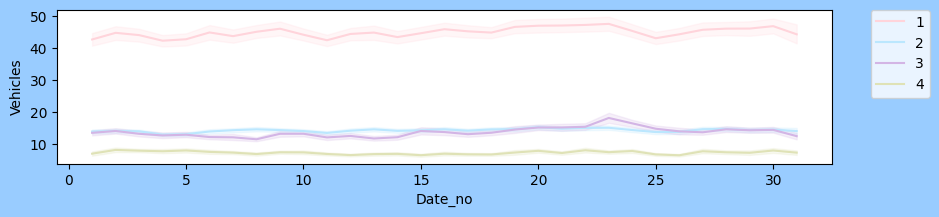

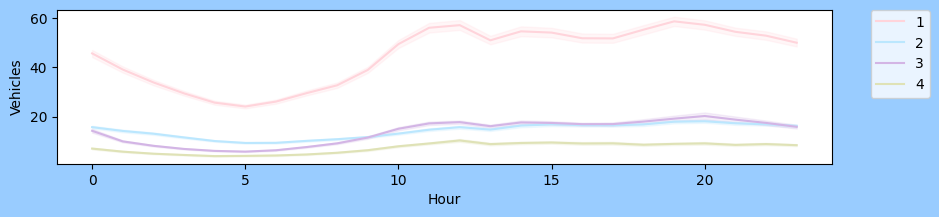

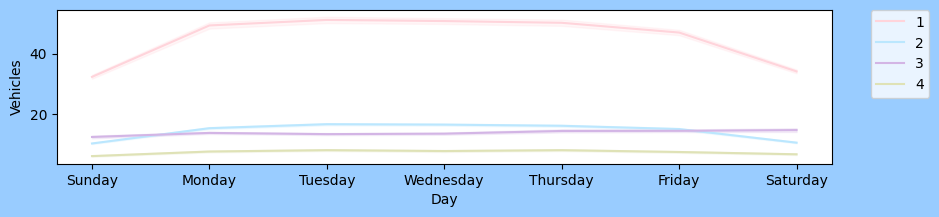

In [7]:
new_features = [ "Year","Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(10, 2),facecolor="#99ccff")
    ax=sns.lineplot(x=df[i],y="Vehicles",data=df, hue="Junction", palette=colors )
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)


Text(0.5, 0, 'Date')

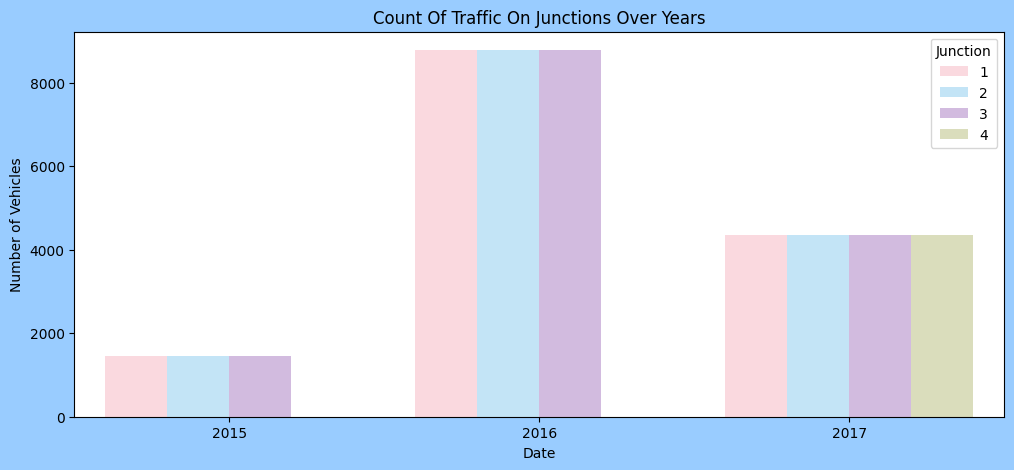

In [8]:
plt.figure(figsize=(12,5),facecolor="#99ccff")
count = sns.countplot(data=df, x =df["Year"], hue="Junction", palette=colors)
count.set_title("Count Of Traffic On Junctions Over Years")
count.set_ylabel("Number of Vehicles")
count.set_xlabel("Date")

<Axes: >

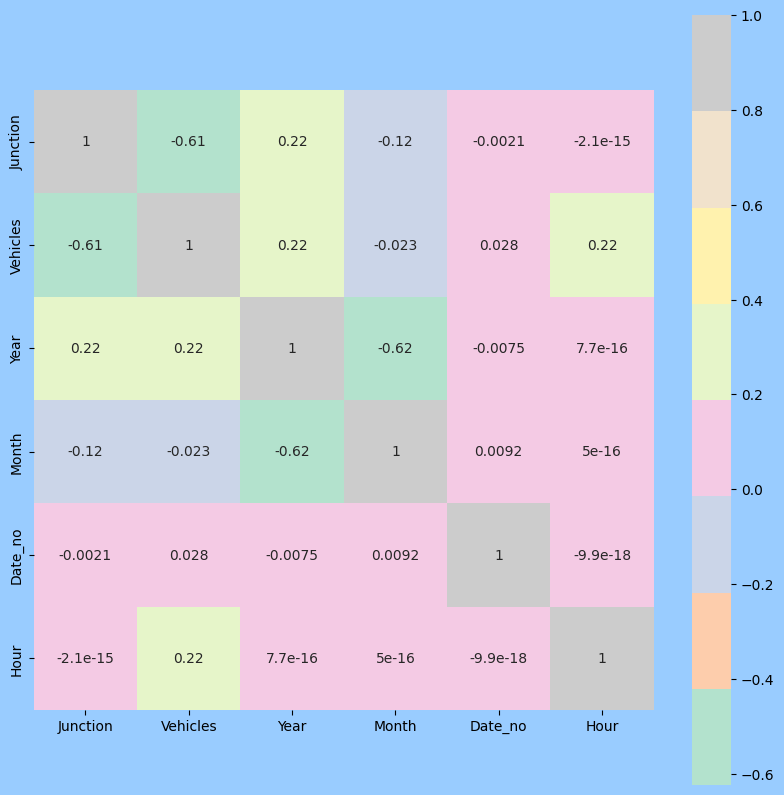

In [9]:
import numpy as np
numeric_df = df.select_dtypes(include=[np.number])

# Compute correlation matrix
corrmat = numeric_df.corr()

# Plot heatmap
plt.subplots(figsize=(10,10),facecolor="#99ccff")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True)

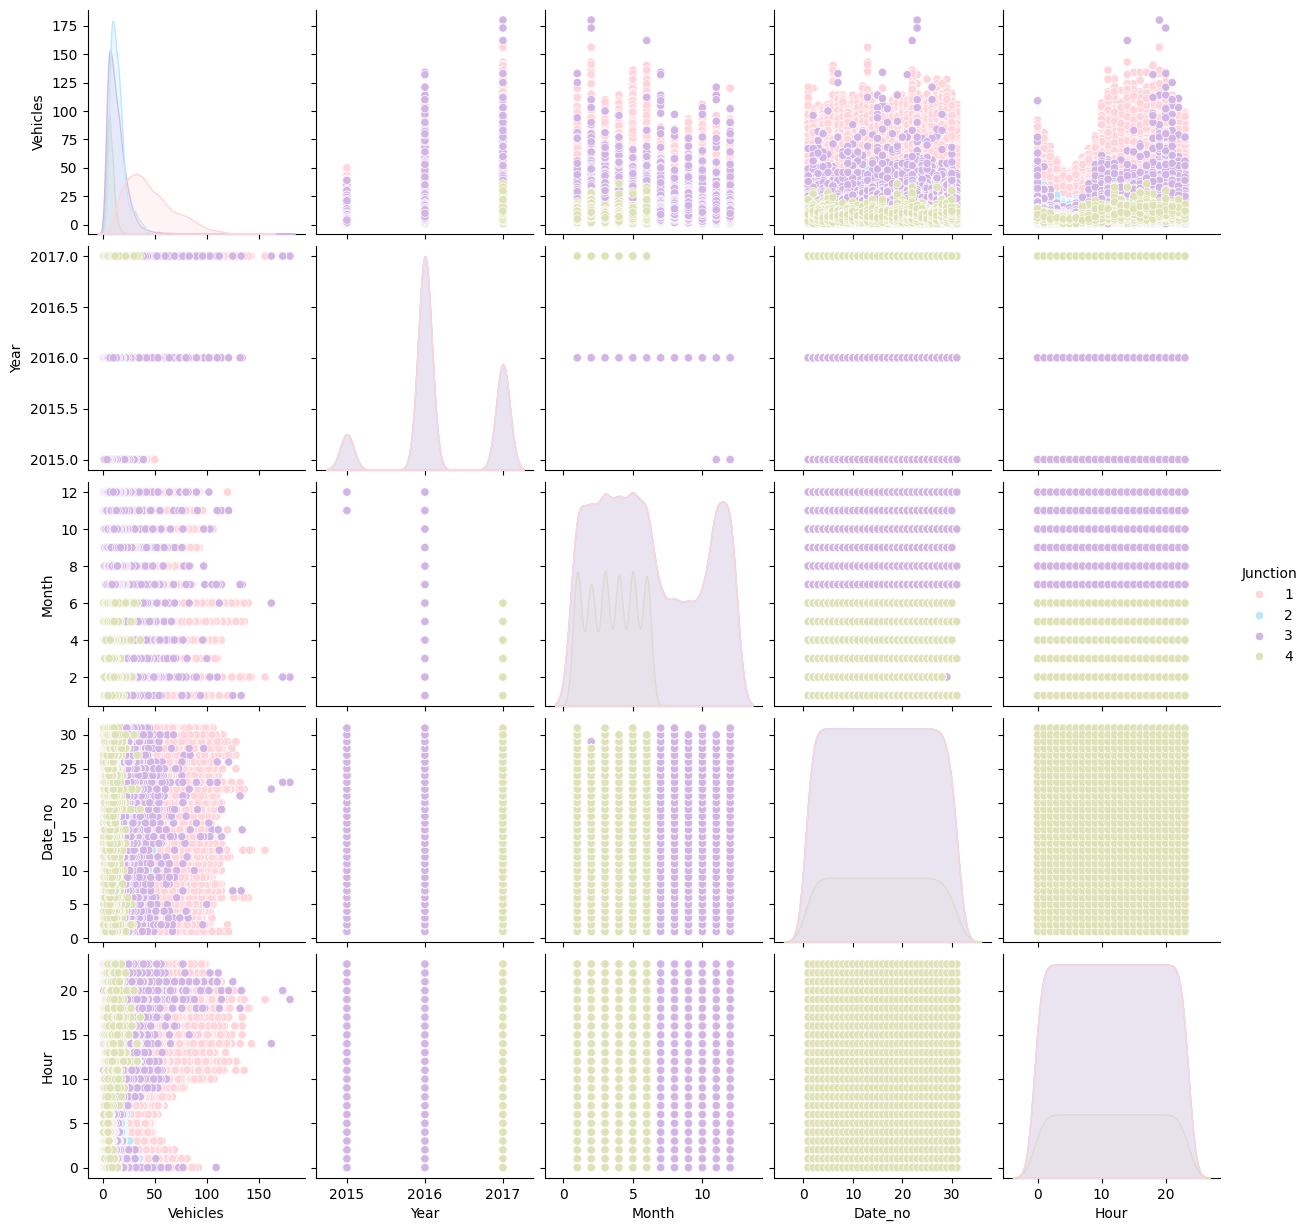

In [10]:
sns.pairplot(data=df, hue= "Junction",palette=colors)


In [11]:
df_J = data.pivot(columns="Junction", index="DateTime")
df_J.describe()

Vehicles                                         
Junction             1             2             3            4
count     14592.000000  14592.000000  14592.000000  4344.000000
mean         45.052906     14.253221     13.694010     7.251611
std          23.008345      7.401307     10.436005     3.521455
min           5.000000      1.000000      1.000000     1.000000
25%          27.000000      9.000000      7.000000     5.000000
50%          40.000000     13.000000     11.000000     7.000000
75%          59.000000     17.000000     18.000000     9.000000
max         156.000000     48.000000    180.000000    36.000000

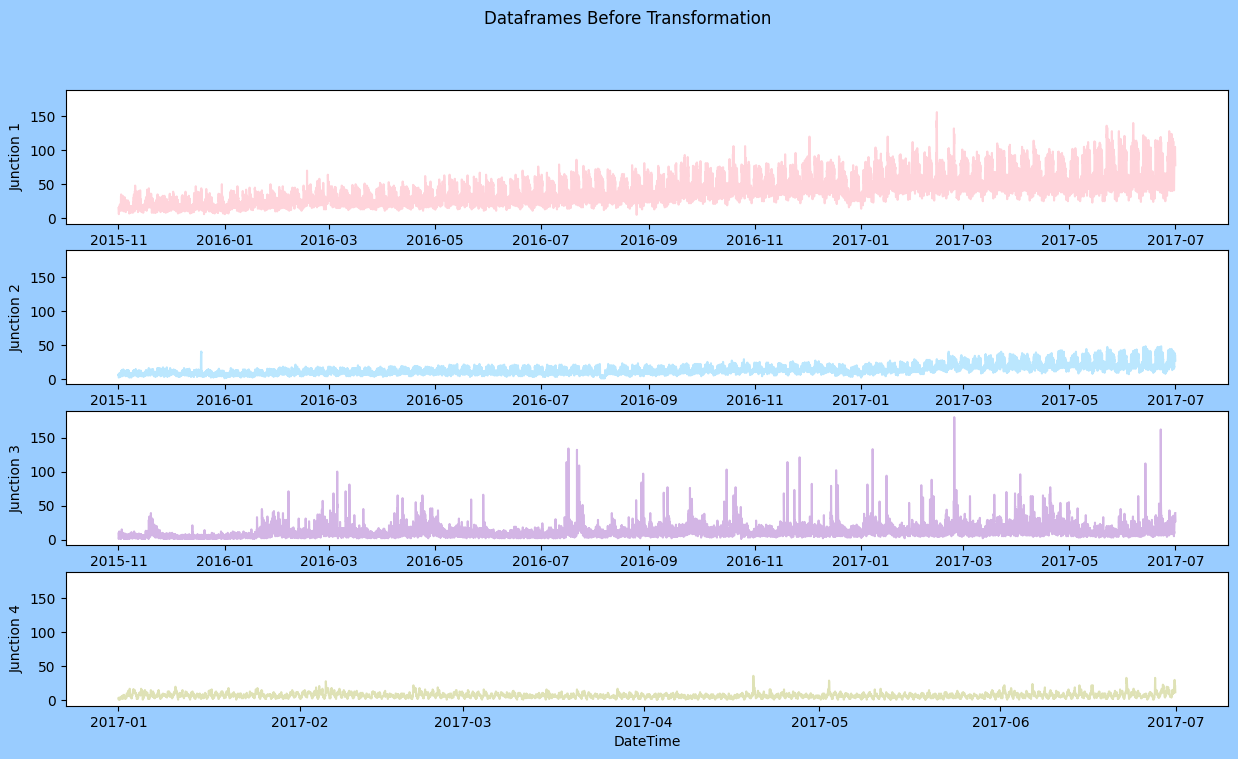

In [12]:
df_1 = df_J[[('Vehicles', 1)]]
df_2 = df_J[[('Vehicles', 2)]]
df_3 = df_J[[('Vehicles', 3)]]
df_4 = df_J[[('Vehicles', 4)]]
df_4 = df_4.dropna() #Junction 4 has limited data only for a few months

#Dropping level one in dfs's index as it is a multi index data frame
list_dfs = [df_1, df_2, df_3, df_4]
for i in list_dfs:
    i.columns= i.columns.droplevel(level=1)

#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, df_2,df_3,df_4,title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#99ccff", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color=colors[0])
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="Junction 1")
    #J2
    pl_2=sns.lineplot(ax=axes[1],data=df_2,color=colors[1])
    axes[1].set(ylabel ="Junction 2")
    #J3
    pl_3=sns.lineplot(ax=axes[2],data=df_3,color=colors[2])
    axes[2].set(ylabel ="Junction 3")
    #J4
    pl_4=sns.lineplot(ax=axes[3],data=df_4,color=colors[3])
    axes[3].set(ylabel ="Junction 4")


#Plotting the dataframe to check for stationarity
Sub_Plots4(df_1.Vehicles, df_2.Vehicles,df_3.Vehicles,df_4.Vehicles,"Dataframes Before Transformation")

In [13]:
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval]
        diff.append(value)
    return diff

In [14]:
df_N1, av_J1, std_J1 = Normalize(df_1, "Vehicles")
Diff_1 = Difference(df_N1, col="Vehicles", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:]
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

df_N2, av_J2, std_J2 = Normalize(df_2, "Vehicles")
Diff_2 = Difference(df_N2, col="Vehicles", interval=(24)) #taking a day's diffrence
df_N2 = df_N2[24:]
df_N2.columns = ["Norm"]
df_N2["Diff"]= Diff_2

df_N3, av_J3, std_J3 = Normalize(df_3, "Vehicles")
Diff_3 = Difference(df_N3, col="Vehicles", interval=1) #taking an hour's diffrence
df_N3 = df_N3[1:]
df_N3.columns = ["Norm"]
df_N3["Diff"]= Diff_3

df_N4, av_J4, std_J4 = Normalize(df_4, "Vehicles")
Diff_4 = Difference(df_N4, col="Vehicles", interval=1) #taking an hour's diffrence
df_N4 = df_N4[1:]
df_N4.columns = ["Norm"]
df_N4["Diff"]= Diff_4

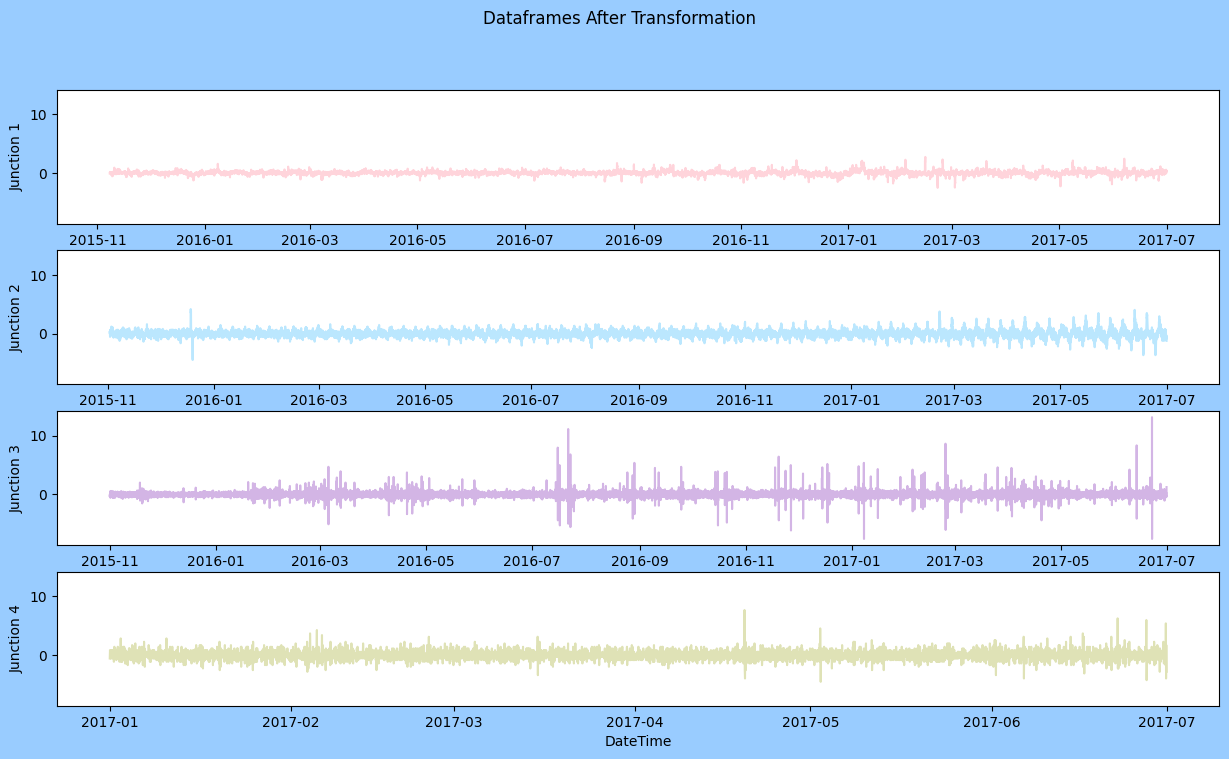

In [15]:
Sub_Plots4(df_N1.Diff, df_N2.Diff,df_N3.Diff,df_N4.Diff,"Dataframes After Transformation")


In [16]:
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary")


#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"], df_N2["Diff"], df_N3["Diff"], df_N4["Diff"]]
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -15.265303390415504
p-value: 4.798539876395756e-28
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -21.79589102694011
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -28.001759908832504
p-value: 0.0
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Time Series is Stationary


ADF Statistic: -17.97909256305238
p-value: 2.7787875325952613e-30
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [17]:
df_J1 = df_N1["Diff"].dropna()
df_J1 = df_J1.to_frame()

df_J2 = df_N2["Diff"].dropna()
df_J2 = df_J2.to_frame()

df_J3 = df_N3["Diff"].dropna()
df_J3 = df_J3.to_frame()

df_J4 = df_N4["Diff"].dropna()
df_J4 = df_J4.to_frame()

#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len]
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test
#Splitting the training and test datasets
J1_train, J1_test = Split_data(df_J1)
J2_train, J2_test = Split_data(df_J2)
J3_train, J3_test = Split_data(df_J3)
J4_train, J4_test = Split_data(df_J4)

#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y

#fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

X_trainJ2, y_trainJ2 = TnF(J2_train)
X_testJ2, y_testJ2 = TnF(J2_test)
X_trainJ2, X_testJ2 = FeatureFixShape(X_trainJ2, X_testJ2)

X_trainJ3, y_trainJ3 = TnF(J3_train)
X_testJ3, y_testJ3 = TnF(J3_test)
X_trainJ3, X_testJ3 = FeatureFixShape(X_trainJ3, X_testJ3)

X_trainJ4, y_trainJ4 = TnF(J4_train)
X_testJ4, y_testJ4 = TnF(J4_test)
X_trainJ4, X_testJ4 = FeatureFixShape(X_trainJ4, X_testJ4)

# **JUNCTION 1 GRU**

In [18]:

early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
modelGRU = Sequential()
modelGRU.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(GRU(units=50, input_shape=(32,1), activation='tanh'))
modelGRU.add(Dropout(0.2))
modelGRU.add(Dense(units=1))


In [19]:
lr_schedule = ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=10000,
    decay_rate=0.9)

In [20]:
modelGRU.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelGRU.fit(X_trainJ1,y_trainJ1, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120,callbacks=[early_stopping])


Epoch 1/50
108/108 [==============================] - 13s 29ms/step - loss: 0.0722 - val_loss: 0.0915
Epoch 2/50
108/108 [==============================] - 2s 14ms/step - loss: 0.0649 - val_loss: 0.0871
Epoch 3/50
108/108 [==============================] - 2s 18ms/step - loss: 0.0631 - val_loss: 0.0831
Epoch 4/50
108/108 [==============================] - 2s 20ms/step - loss: 0.0607 - val_loss: 0.0843
Epoch 5/50
108/108 [==============================] - 2s 16ms/step - loss: 0.0603 - val_loss: 0.0774
Epoch 6/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0582 - val_loss: 0.0751
Epoch 7/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0579 - val_loss: 0.0736
Epoch 8/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0567 - val_loss: 0.0717
Epoch 9/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0568 - val_loss: 0.0705
Epoch 10/50
108/108 [==============================] - 2s 14ms/step - loss: 0.0549 - val_l

In [22]:
pred_GRUJ1= modelGRU.predict(X_testJ1)

45/45 [==============================] - 2s 7ms/step


In [29]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseGRUJ1= mean_squared_error(y_testJ1, pred_GRUJ1)

# Calculate RMSE
rmseGRUJ1 = np.sqrt(mseGRUJ1)

# Calculate MAE
maeGRUJ1 = mean_absolute_error(y_testJ1, pred_GRUJ1)

print("MSE:", mseGRUJ1)
print("RMSE:", rmseGRUJ1)
print("MAE:", maeGRUJ1)


MSE: 0.06142963747179946
RMSE: 0.24785003020334587
MAE: 0.17819858978466063


**GRU JUNCTION 2**

In [30]:

early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
modelGRUJ2 = Sequential()
modelGRUJ2.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ2.add(Dropout(0.2))
modelGRUJ2.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ2.add(Dropout(0.2))
modelGRUJ2.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ2.add(Dropout(0.2))
modelGRUJ2.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ2.add(Dropout(0.2))
modelGRUJ2.add(GRU(units=50, input_shape=(32,1), activation='tanh'))
modelGRUJ2.add(Dropout(0.2))
modelGRUJ2.add(Dense(units=1))
modelGRUJ2.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelGRUJ2.fit(X_trainJ2,y_trainJ2, validation_data=(X_testJ2, y_testJ2), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_GRUJ2= modelGRUJ2.predict(X_testJ2)


Epoch 1/50
109/109 [==============================] - 11s 29ms/step - loss: 0.2324 - val_loss: 0.4397
Epoch 2/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2046 - val_loss: 0.3762
Epoch 3/50
109/109 [==============================] - 2s 15ms/step - loss: 0.1974 - val_loss: 0.3605
Epoch 4/50
109/109 [==============================] - 2s 15ms/step - loss: 0.1960 - val_loss: 0.3445
Epoch 5/50
109/109 [==============================] - 2s 19ms/step - loss: 0.1913 - val_loss: 0.3424
Epoch 6/50
109/109 [==============================] - 2s 18ms/step - loss: 0.1918 - val_loss: 0.3421
Epoch 7/50
109/109 [==============================] - 2s 14ms/step - loss: 0.1915 - val_loss: 0.3367
Epoch 8/50
109/109 [==============================] - 2s 14ms/step - loss: 0.1900 - val_loss: 0.3260
Epoch 9/50
109/109 [==============================] - 2s 14ms/step - loss: 0.1885 - val_loss: 0.3420
Epoch 10/50
109/109 [==============================] - 2s 14ms/step - loss: 0.1904 - val_l

In [31]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseGRUJ2= mean_squared_error(y_testJ2, pred_GRUJ2)

# Calculate RMSE
rmseGRUJ2 = np.sqrt(mseGRUJ2)

# Calculate MAE
maeGRUJ2 = mean_absolute_error(y_testJ2, pred_GRUJ2)

print("MSE:", mseGRUJ2)
print("RMSE:", rmseGRUJ2)
print("MAE:", maeGRUJ2)


MSE: 0.3095913710697338
RMSE: 0.5564093556633765
MAE: 0.4329503961970582


**GRU Junction 3**

In [33]:

early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
modelGRUJ3 = Sequential()
modelGRUJ3.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ3.add(Dropout(0.2))
modelGRUJ3.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ3.add(Dropout(0.2))
modelGRUJ3.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ3.add(Dropout(0.2))
modelGRUJ3.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ3.add(Dropout(0.2))
modelGRUJ3.add(GRU(units=50, input_shape=(32,1), activation='tanh'))
modelGRUJ3.add(Dropout(0.2))
modelGRUJ3.add(Dense(units=1))
modelGRUJ3.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelGRUJ3.fit(X_trainJ3,y_trainJ3, validation_data=(X_testJ3, y_testJ3), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_GRUJ3= modelGRUJ3.predict(X_testJ3)


Epoch 1/50
110/110 [==============================] - 11s 37ms/step - loss: 0.3022 - val_loss: 0.4013
Epoch 2/50
110/110 [==============================] - 2s 16ms/step - loss: 0.2950 - val_loss: 0.3963
Epoch 3/50
110/110 [==============================] - 2s 14ms/step - loss: 0.2935 - val_loss: 0.3969
Epoch 4/50
110/110 [==============================] - 2s 14ms/step - loss: 0.2921 - val_loss: 0.3956
Epoch 5/50
110/110 [==============================] - 2s 14ms/step - loss: 0.2892 - val_loss: 0.4055
Epoch 6/50
110/110 [==============================] - 2s 15ms/step - loss: 0.2901 - val_loss: 0.3941
Epoch 7/50
110/110 [==============================] - 2s 14ms/step - loss: 0.2866 - val_loss: 0.3995
Epoch 8/50
110/110 [==============================] - 2s 17ms/step - loss: 0.2886 - val_loss: 0.3922
Epoch 9/50
110/110 [==============================] - 2s 19ms/step - loss: 0.2871 - val_loss: 0.4152
Epoch 10/50
110/110 [==============================] - 2s 16ms/step - loss: 0.2878 - val_l

In [34]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseGRUJ3= mean_squared_error(y_testJ3, pred_GRUJ3)

# Calculate RMSE
rmseGRUJ3 = np.sqrt(mseGRUJ3)

# Calculate MAE
maeGRUJ3 = mean_absolute_error(y_testJ3, pred_GRUJ3)

print("MSE:", mseGRUJ3)
print("RMSE:", rmseGRUJ3)
print("MAE:", maeGRUJ3)


MSE: 0.36928108389174863
RMSE: 0.6076850202956698
MAE: 0.2997081895643235


**GRU Junction 4**

In [35]:

early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True)
modelGRUJ4 = Sequential()
modelGRUJ4.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ4.add(Dropout(0.2))
modelGRUJ4.add(GRU(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ4.add(Dropout(0.2))
modelGRUJ4.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ4.add(Dropout(0.2))
modelGRUJ4.add(GRU(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelGRUJ4.add(Dropout(0.2))
modelGRUJ4.add(GRU(units=50, input_shape=(32,1), activation='tanh'))
modelGRUJ4.add(Dropout(0.2))
modelGRUJ4.add(Dense(units=1))
modelGRUJ4.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelGRUJ4.fit(X_trainJ4,y_trainJ4, validation_data=(X_testJ4, y_testJ4), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_GRUJ4= modelGRUJ4.predict(X_testJ4)


Epoch 1/50
33/33 [==============================] - 10s 62ms/step - loss: 0.6922 - val_loss: 1.2557
Epoch 2/50
33/33 [==============================] - 1s 15ms/step - loss: 0.6988 - val_loss: 1.2428
Epoch 3/50
33/33 [==============================] - 0s 15ms/step - loss: 0.6887 - val_loss: 1.2419
Epoch 4/50
33/33 [==============================] - 1s 15ms/step - loss: 0.6909 - val_loss: 1.2477
Epoch 5/50
33/33 [==============================] - 0s 15ms/step - loss: 0.6861 - val_loss: 1.2362
Epoch 6/50
33/33 [==============================] - 1s 16ms/step - loss: 0.6827 - val_loss: 1.2401
Epoch 7/50
33/33 [==============================] - 0s 14ms/step - loss: 0.6845 - val_loss: 1.2311
Epoch 8/50
33/33 [==============================] - 1s 16ms/step - loss: 0.6801 - val_loss: 1.2271
Epoch 9/50
33/33 [==============================] - 0s 15ms/step - loss: 0.6824 - val_loss: 1.2284
Epoch 10/50
33/33 [==============================] - 1s 20ms/step - loss: 0.6788 - val_loss: 1.2246
Epoch 11

In [37]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseGRUJ4= mean_squared_error(y_testJ4, pred_GRUJ4)

# Calculate RMSE
rmseGRUJ4 = np.sqrt(mseGRUJ4)

# Calculate MAE
maeGRUJ4 = mean_absolute_error(y_testJ4, pred_GRUJ4)

print("MSE:", mseGRUJ4)
print("RMSE:", rmseGRUJ4)
print("MAE:", maeGRUJ4)


MSE: 0.9957637806411723
RMSE: 0.9978796423623304
MAE: 0.7070032100482007


**LSTM Junction 1**

In [40]:
modelLSTMJ1 = Sequential()
modelLSTMJ1.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ1.add(Dropout(0.2))
modelLSTMJ1.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ1.add(Dropout(0.2))
modelLSTMJ1.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ1.add(Dropout(0.2))
modelLSTMJ1.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ1.add(Dropout(0.2))
modelLSTMJ1.add(LSTM(units=50, input_shape=(32,1), activation='tanh'))
modelLSTMJ1.add(Dropout(0.2))
modelLSTMJ1.add(Dense(units=1))
modelLSTMJ1.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelLSTMJ1.fit(X_trainJ1,y_trainJ1, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_LSTMJ1 = modelLSTMJ1.predict(X_testJ1)

Epoch 1/50
108/108 [==============================] - 14s 53ms/step - loss: 0.0915 - val_loss: 0.1144
Epoch 2/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0836 - val_loss: 0.1124
Epoch 3/50
108/108 [==============================] - 2s 14ms/step - loss: 0.0816 - val_loss: 0.1111
Epoch 4/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0811 - val_loss: 0.1090
Epoch 5/50
108/108 [==============================] - 2s 21ms/step - loss: 0.0796 - val_loss: 0.1095
Epoch 6/50
108/108 [==============================] - 2s 20ms/step - loss: 0.0798 - val_loss: 0.1098
Epoch 7/50
108/108 [==============================] - 2s 20ms/step - loss: 0.0782 - val_loss: 0.1088
Epoch 8/50
108/108 [==============================] - 2s 17ms/step - loss: 0.0778 - val_loss: 0.1092
Epoch 9/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0769 - val_loss: 0.1083
Epoch 10/50
108/108 [==============================] - 2s 15ms/step - loss: 0.0767 - val_l

In [41]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseLSTMJ1= mean_squared_error(y_testJ1, pred_LSTMJ1)

# Calculate RMSE
rmseLSTMJ1= np.sqrt(mseLSTMJ1)

# Calculate MAE
maeLSTMJ1= mean_absolute_error(y_testJ1, pred_LSTMJ1)

print("MSE:", mseLSTMJ1)
print("RMSE:", rmseLSTMJ1)
print("MAE:", maeLSTMJ1)


MSE: 0.07403255137768425
RMSE: 0.2720892342186369
MAE: 0.19142669452678415


**LSTM Junction 2**

In [42]:
modelLSTMJ2 = Sequential()
modelLSTMJ2.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ2.add(Dropout(0.2))
modelLSTMJ2.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ2.add(Dropout(0.2))
modelLSTMJ2.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ2.add(Dropout(0.2))
modelLSTMJ2.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ2.add(Dropout(0.2))
modelLSTMJ2.add(LSTM(units=50, input_shape=(32,1), activation='tanh'))
modelLSTMJ2.add(Dropout(0.2))
modelLSTMJ2.add(Dense(units=1))
modelLSTMJ2.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelLSTMJ2.fit(X_trainJ2,y_trainJ2, validation_data=(X_testJ2, y_testJ2), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_LSTMJ2 = modelLSTMJ2.predict(X_testJ2)

Epoch 1/50
109/109 [==============================] - 12s 30ms/step - loss: 0.2984 - val_loss: 0.7493
Epoch 2/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2620 - val_loss: 0.6098
Epoch 3/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2440 - val_loss: 0.6038
Epoch 4/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2336 - val_loss: 0.5462
Epoch 5/50
109/109 [==============================] - 2s 20ms/step - loss: 0.2270 - val_loss: 0.5728
Epoch 6/50
109/109 [==============================] - 2s 20ms/step - loss: 0.2247 - val_loss: 0.5258
Epoch 7/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2213 - val_loss: 0.5184
Epoch 8/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2197 - val_loss: 0.4927
Epoch 9/50
109/109 [==============================] - 2s 14ms/step - loss: 0.2168 - val_loss: 0.5153
Epoch 10/50
109/109 [==============================] - 2s 15ms/step - loss: 0.2145 - val_l

In [43]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseLSTMJ2= mean_squared_error(y_testJ2, pred_LSTMJ2)

# Calculate RMSE
rmseLSTMJ2= np.sqrt(mseLSTMJ2)

# Calculate MAE
maeLSTMJ2= mean_absolute_error(y_testJ2, pred_LSTMJ2)

print("MSE:", mseLSTMJ2)
print("RMSE:", rmseLSTMJ2)
print("MAE:", maeLSTMJ2)


MSE: 0.3227092579573673
RMSE: 0.5680750460611409
MAE: 0.44178002951136214


**LSTM Junction 3**

In [44]:
modelLSTMJ3 = Sequential()
modelLSTMJ3.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ3.add(Dropout(0.2))
modelLSTMJ3.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ3.add(Dropout(0.2))
modelLSTMJ3.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ3.add(Dropout(0.2))
modelLSTMJ3.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ3.add(Dropout(0.2))
modelLSTMJ3.add(LSTM(units=50, input_shape=(32,1), activation='tanh'))
modelLSTMJ3.add(Dropout(0.2))
modelLSTMJ3.add(Dense(units=1))
modelLSTMJ3.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelLSTMJ3.fit(X_trainJ3,y_trainJ3, validation_data=(X_testJ3, y_testJ3), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_LSTMJ3 = modelLSTMJ3.predict(X_testJ3)

Epoch 1/50
110/110 [==============================] - 17s 43ms/step - loss: 0.3047 - val_loss: 0.4025
Epoch 2/50
110/110 [==============================] - 3s 30ms/step - loss: 0.3043 - val_loss: 0.4026
Epoch 3/50
110/110 [==============================] - 3s 28ms/step - loss: 0.3054 - val_loss: 0.4015
Epoch 4/50
110/110 [==============================] - 3s 29ms/step - loss: 0.3029 - val_loss: 0.4006
Epoch 5/50
110/110 [==============================] - 2s 20ms/step - loss: 0.3017 - val_loss: 0.4006
Epoch 6/50
110/110 [==============================] - 3s 24ms/step - loss: 0.3006 - val_loss: 0.4004
Epoch 7/50
110/110 [==============================] - 2s 20ms/step - loss: 0.2985 - val_loss: 0.3926
Epoch 8/50
110/110 [==============================] - 3s 24ms/step - loss: 0.2957 - val_loss: 0.3909
Epoch 9/50
110/110 [==============================] - 3s 23ms/step - loss: 0.2938 - val_loss: 0.3855
Epoch 10/50
110/110 [==============================] - 2s 15ms/step - loss: 0.2911 - val_l

In [45]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseLSTMJ3= mean_squared_error(y_testJ3, pred_LSTMJ3)

# Calculate RMSE
rmseLSTMJ3= np.sqrt(mseLSTMJ3)

# Calculate MAE
maeLSTMJ3= mean_absolute_error(y_testJ3, pred_LSTMJ3)

print("MSE:", mseLSTMJ3)
print("RMSE:", rmseLSTMJ3)
print("MAE:", maeLSTMJ3)


MSE: 0.38429879516963406
RMSE: 0.6199183778285929
MAE: 0.3036600333496379


**LSTM Junction 4**

In [46]:
modelLSTMJ4 = Sequential()
modelLSTMJ4.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ4.add(Dropout(0.2))
modelLSTMJ4.add(LSTM(units=150, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ4.add(Dropout(0.2))
modelLSTMJ4.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ4.add(Dropout(0.2))
modelLSTMJ4.add(LSTM(units=50, return_sequences=True, input_shape=(32,1), activation='tanh'))
modelLSTMJ4.add(Dropout(0.2))
modelLSTMJ4.add(LSTM(units=50, input_shape=(32,1), activation='tanh'))
modelLSTMJ4.add(Dropout(0.2))
modelLSTMJ4.add(Dense(units=1))
modelLSTMJ4.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelLSTMJ4.fit(X_trainJ4,y_trainJ4, validation_data=(X_testJ4, y_testJ4), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_LSTMJ4 = modelLSTMJ4.predict(X_testJ4)

Epoch 1/50
33/33 [==============================] - 20s 184ms/step - loss: 0.6897 - val_loss: 1.2514
Epoch 2/50
33/33 [==============================] - 1s 24ms/step - loss: 0.6929 - val_loss: 1.2462
Epoch 3/50
33/33 [==============================] - 1s 24ms/step - loss: 0.6939 - val_loss: 1.2465
Epoch 4/50
33/33 [==============================] - 1s 23ms/step - loss: 0.6896 - val_loss: 1.2563
Epoch 5/50
33/33 [==============================] - 1s 23ms/step - loss: 0.6934 - val_loss: 1.2452
Epoch 6/50
33/33 [==============================] - 1s 22ms/step - loss: 0.6914 - val_loss: 1.2469
Epoch 7/50
33/33 [==============================] - 1s 20ms/step - loss: 0.6920 - val_loss: 1.2455
Epoch 8/50
33/33 [==============================] - 1s 15ms/step - loss: 0.6903 - val_loss: 1.2447
Epoch 9/50
33/33 [==============================] - 1s 15ms/step - loss: 0.6904 - val_loss: 1.2443
Epoch 10/50
33/33 [==============================] - 1s 17ms/step - loss: 0.6890 - val_loss: 1.2442
Epoch 1

In [47]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate MSE
mseLSTMJ4= mean_squared_error(y_testJ4, pred_LSTMJ4)

# Calculate RMSE
rmseLSTMJ4= np.sqrt(mseLSTMJ3)

# Calculate MAE
maeLSTMJ4= mean_absolute_error(y_testJ4, pred_LSTMJ4)

print("MSE:", mseLSTMJ4)
print("RMSE:", rmseLSTMJ4)
print("MAE:", maeLSTMJ4)


MSE: 1.2012944335619238
RMSE: 0.6199183778285929
MAE: 0.7828736881750424


**CNN Junction 1**

In [48]:
modelCNNJ1 = Sequential()
modelCNNJ1.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 1)))
modelCNNJ1.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelCNNJ1.add(Dropout(0.5))
modelCNNJ1.add(MaxPooling1D(pool_size=2))
modelCNNJ1.add(Flatten())
modelCNNJ1.add(Dense(50, activation='relu'))
modelCNNJ1.add(Dense(units=1))
modelCNNJ1.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelCNNJ1.fit(X_trainJ1,y_trainJ1, validation_data=(X_testJ1, y_testJ1), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_CNNJ1 = modelCNNJ1.predict(X_testJ1)

Epoch 1/50
108/108 [==============================] - 3s 10ms/step - loss: 0.0693 - val_loss: 0.0795
Epoch 2/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0580 - val_loss: 0.0720
Epoch 3/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0542 - val_loss: 0.0687
Epoch 4/50
108/108 [==============================] - 1s 6ms/step - loss: 0.0518 - val_loss: 0.0678
Epoch 5/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0499 - val_loss: 0.0675
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0496 - val_loss: 0.0678
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0486 - val_loss: 0.0637
Epoch 8/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0476 - val_loss: 0.0636
Epoch 9/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0475 - val_loss: 0.0623
Epoch 10/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0463 - val_loss: 0.063

In [49]:

mseCNNJ1= mean_squared_error(y_testJ1, pred_CNNJ1)

# Calculate RMSE
rmseCNNJ1= np.sqrt(mseCNNJ1)

# Calculate MAE
maeCNNJ1= mean_absolute_error(y_testJ1, pred_CNNJ1)

print("MSE:", mseCNNJ1)
print("RMSE:", rmseCNNJ1)
print("MAE:", maeCNNJ1)


MSE: 0.0610713542359092
RMSE: 0.24712619091449858
MAE: 0.1756387863252348


**CNN Junction 2**

In [50]:
modelCNNJ2 = Sequential()
modelCNNJ2.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 1)))
modelCNNJ2.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelCNNJ2.add(Dropout(0.5))
modelCNNJ2.add(MaxPooling1D(pool_size=2))
modelCNNJ2.add(Flatten())
modelCNNJ2.add(Dense(50, activation='relu'))
modelCNNJ2.add(Dense(units=1))
modelCNNJ2.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelCNNJ2.fit(X_trainJ2,y_trainJ2, validation_data=(X_testJ2, y_testJ2), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_CNNJ2 = modelCNNJ2.predict(X_testJ2)

Epoch 1/50
109/109 [==============================] - 2s 7ms/step - loss: 0.2140 - val_loss: 0.4277
Epoch 2/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1708 - val_loss: 0.3769
Epoch 3/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1598 - val_loss: 0.3543
Epoch 4/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1540 - val_loss: 0.3225
Epoch 5/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1547 - val_loss: 0.3463
Epoch 6/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1503 - val_loss: 0.3426
Epoch 7/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1495 - val_loss: 0.3463
Epoch 8/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1484 - val_loss: 0.3398
Epoch 9/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1469 - val_loss: 0.3134
Epoch 10/50
109/109 [==============================] - 0s 4ms/step - loss: 0.1462 - val_loss: 0.2980

In [51]:

mseCNNJ2= mean_squared_error(y_testJ2, pred_CNNJ2)

# Calculate RMSE
rmseCNNJ2= np.sqrt(mseCNNJ2)

# Calculate MAE
maeCNNJ2= mean_absolute_error(y_testJ2, pred_CNNJ2)

print("MSE:", mseCNNJ2)
print("RMSE:", rmseCNNJ2)
print("MAE:", maeCNNJ2)


MSE: 0.2805192324855355
RMSE: 0.5296406635498595
MAE: 0.409322779028131


**CNN Junction 3**

In [52]:
modelCNNJ3 = Sequential()
modelCNNJ3.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 1)))
modelCNNJ3.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelCNNJ3.add(Dropout(0.5))
modelCNNJ3.add(MaxPooling1D(pool_size=2))
modelCNNJ3.add(Flatten())
modelCNNJ3.add(Dense(50, activation='relu'))
modelCNNJ3.add(Dense(units=1))
modelCNNJ3.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelCNNJ3.fit(X_trainJ3,y_trainJ3, validation_data=(X_testJ3, y_testJ3), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_CNNJ3 = modelCNNJ3.predict(X_testJ3)

Epoch 1/50
110/110 [==============================] - 2s 7ms/step - loss: 0.2869 - val_loss: 0.3700
Epoch 2/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2645 - val_loss: 0.3526
Epoch 3/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2563 - val_loss: 0.3459
Epoch 4/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2553 - val_loss: 0.3434
Epoch 5/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2520 - val_loss: 0.3451
Epoch 6/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2486 - val_loss: 0.3511
Epoch 7/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2482 - val_loss: 0.3398
Epoch 8/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2454 - val_loss: 0.3355
Epoch 9/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2433 - val_loss: 0.3447
Epoch 10/50
110/110 [==============================] - 0s 4ms/step - loss: 0.2431 - val_loss: 0.3576

In [53]:

mseCNNJ3= mean_squared_error(y_testJ3, pred_CNNJ3)

# Calculate RMSE
rmseCNNJ3= np.sqrt(mseCNNJ3)

# Calculate MAE
maeCNNJ3= mean_absolute_error(y_testJ3, pred_CNNJ3)

print("MSE:", mseCNNJ3)
print("RMSE:", rmseCNNJ3)
print("MAE:", maeCNNJ3)


MSE: 0.3355093294856573
RMSE: 0.5792316716872942
MAE: 0.2871156170426567


**CNN Junction 4**

In [54]:
modelCNNJ4 = Sequential()
modelCNNJ4.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(32, 1)))
modelCNNJ4.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
modelCNNJ4.add(Dropout(0.5))
modelCNNJ4.add(MaxPooling1D(pool_size=2))
modelCNNJ4.add(Flatten())
modelCNNJ4.add(Dense(50, activation='relu'))
modelCNNJ4.add(Dense(units=1))
modelCNNJ4.compile(optimizer=SGD(learning_rate=lr_schedule, momentum=0.9),loss='mean_squared_error')
modelCNNJ4.fit(X_trainJ4,y_trainJ4, validation_data=(X_testJ4, y_testJ4), epochs=50, batch_size=120,callbacks=[early_stopping])
pred_CNNJ4 = modelCNNJ4.predict(X_testJ4)

Epoch 1/50
33/33 [==============================] - 1s 16ms/step - loss: 0.7070 - val_loss: 1.2279
Epoch 2/50
33/33 [==============================] - 0s 5ms/step - loss: 0.6730 - val_loss: 1.1796
Epoch 3/50
33/33 [==============================] - 0s 5ms/step - loss: 0.6462 - val_loss: 1.1351
Epoch 4/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5977 - val_loss: 1.0869
Epoch 5/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5791 - val_loss: 1.0862
Epoch 6/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5652 - val_loss: 1.0768
Epoch 7/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5577 - val_loss: 1.0595
Epoch 8/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5482 - val_loss: 1.0407
Epoch 9/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5607 - val_loss: 1.1303
Epoch 10/50
33/33 [==============================] - 0s 5ms/step - loss: 0.5418 - val_loss: 1.0405
Epoch 11/50
33/33 

In [55]:

mseCNNJ4= mean_squared_error(y_testJ4, pred_CNNJ4)

# Calculate RMSE
rmseCNNJ4= np.sqrt(mseCNNJ4)

# Calculate MAE
maeCNNJ4= mean_absolute_error(y_testJ4, pred_CNNJ4)

print("MSE:", mseCNNJ4)
print("RMSE:", rmseCNNJ4)
print("MAE:", maeCNNJ4)


MSE: 0.9964853935850927
RMSE: 0.9982411500159131
MAE: 0.6996152998980939


In [58]:
print("Mean MAE for CNN across all Junctions:", np.mean(np.array([maeCNNJ1,maeCNNJ2, maeCNNJ3, maeCNNJ4])))
print("Mean MSE for CNN across all Junctions:", np.mean(np.array([mseCNNJ1,mseCNNJ2, mseCNNJ3, mseCNNJ4])))
print("Mean RMSE for CNN across all Junctions:", np.mean(np.array([rmseCNNJ1,rmseCNNJ2, rmseCNNJ3, rmseCNNJ4])))



Mean MAE for CNN across all Junctions: 0.39292312057352907
Mean MSE for CNN across all Junctions: 0.41839632744804867
Mean RMSE for CNN across all Junctions: 0.5885599190418913


In [59]:
print("Mean MAE for LSTM across all Junctions:", np.mean(np.array([maeLSTMJ1,maeLSTMJ2, maeLSTMJ3, maeLSTMJ4])))
print("Mean MSE for LSTM across all Junctions:", np.mean(np.array([mseLSTMJ1,mseLSTMJ2, mseLSTMJ3, mseLSTMJ4])))
print("Mean RMSE for LSTM across all Junctions:", np.mean(np.array([rmseLSTMJ1,rmseLSTMJ2, rmseLSTMJ3, rmseLSTMJ4])))



Mean MAE for LSTM across all Junctions: 0.42993511139070667
Mean MSE for LSTM across all Junctions: 0.49558375951665234
Mean RMSE for LSTM across all Junctions: 0.520000258984241


In [60]:
print("Mean MAE for GRU across all Junctions:", np.mean(np.array([maeGRUJ1,maeGRUJ2, maeGRUJ3, maeGRUJ4])))
print("Mean MSE for GRU across all Junctions:", np.mean(np.array([mseGRUJ1,mseGRUJ2, mseGRUJ3, mseGRUJ4])))
print("Mean RMSE for GRU across all Junctions:", np.mean(np.array([rmseGRUJ1,rmseGRUJ2, rmseGRUJ3, rmseGRUJ4])))



Mean MAE for GRU across all Junctions: 0.40446509639856076
Mean MSE for GRU across all Junctions: 0.43401646826861356
Mean RMSE for GRU across all Junctions: 0.6024560121311806


In [56]:
modelGRU.save("modelGRUJ1.keras")
modelGRUJ2.save("modelGRUJ2.keras")
modelGRUJ3.save("modelGRUJ3.keras")
modelGRUJ4.save("modelGRUJ4.keras")
modelLSTMJ1.save("modelLSTMJ1.keras")
modelLSTMJ2.save("modelLSTMJ2.keras")
modelLSTMJ3.save("modelLSTMJ3.keras")
modelLSTMJ4.save("modelLSTMJ4.keras")
modelCNNJ1.save("modelCNNJ1.keras")
modelCNNJ2.save("modelCNNJ2.keras")
modelCNNJ3.save("modelCNNJ3.keras")
modelCNNJ4.save("modelCNNJ4.keras")